In [23]:
import numpy as np
from numpy.fft import fft2, ifft2
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import measure
from collections import defaultdict

# OCR - Optical Character Recognition

Spis treści:
- ...
- ...

# Założenia

- Tekst składa się z małych liter alfabetu łacińskiego oraz cyfr.
- Na obrazie występuje jeden typ i rozmiar czcionki.
- Występują znaki przestankowe:   .  ,  !  ?
- Tekst składa się z wielu linii.
- Tekst może być obrócony.
- Program pownien zwracać tekst wraz ze znakami białymi i znakami nowej linii.
- Program powinien zliczać liczbę wystąpień każdego znaku.

TODO:
- SZERYFOWE I NIE SZERYFOWE -> porównaj
- może raportować % poprawności dla predefiniowanych testów
- operacja splotu i dft
- redukcja szumu
- obrót
- czytanie lini i spacji

# Wczytywanie obrazu

Obraz wczytuję za pomocą biblioteki PIL i konwertuję go na skalę szarości

In [24]:
def load_image(filepath):
    return ImageOps.invert(Image.open(filepath).convert('L'))

# Wczytywanie czcionek

Do mojego programu przygotowałem dwa zestawy czcionek: 
- szeryfową (serif)
- nie szeryfową (sans-serif)  

Każdy zestaw zawiera 26 liter alfabetu łacińskiego, 4 znaki przestankowe, 10 cyfr oraz obraz wszystkich znaków w jednym pliku.  
Wczytuję je z plików .png, konwertuję na skalę szarości i zapisuję w tablicy numpy za pomocą powyżej zdefiniowanej funkcji.

In [25]:
def load_fonts():
    fonts = {font: {char[:-4]: load_image(f'./fonts/{font}/{char}') for char in os.listdir(f'./fonts/{font}')} for font in os.listdir('fonts')}
    key_mappings = [('exclamation-mark', '!'), ('question-mark', '?'), ('dot', '.'), ('comma', ',')]
    for _, font in fonts.items():
        for old_key, new_key in key_mappings:
            font[new_key] = font[old_key]
            del font[old_key]
    return fonts

# Dodanie wszystkich znaków do obrazu 

Aby mieć pewność, że znak został rozpoznany, dodaję do obrazu wszystkie wzorce znaków z wybranego zestawu czcionek, które będą porównywane z obrazem wejściowym. Dzięki temu dodane wzorce powinny mieć największe wartości korelacji, właśnie z tą wartością będę porównywał obraz wejściowy.

In [26]:
def add_char_patterns(image, font):
    patterns = font['all']
    result = Image.new('L', (max(image.width, patterns.width), image.height + patterns.height), 0)
    result.paste(image, (0, 0))
    result.paste(patterns, (0, image.height))
    return result

# Korelacja

In [27]:
def correlation(image, sample):
    return np.real(ifft2(np.multiply(fft2(np.array(image)), fft2(np.rot90(sample, 2), np.array(image).shape))))

# Kolejność wykrywania znaków

Kolejność wykrywania znaków ustalam na podstawie odwrotnej listy liczby wykrytych znaków w obrazie zawierającym wszystkie znaki - skoro z daną pewnością wykryłem pewien znak więcej niż jeden raz to jest większa szansa na pomylenie go w obrazie wejściowym.

Głównym powodem takiego stanu jest podobieństwo niektórych znaków, np. 'i' i 'l', oraz zawieranie się niektórych znaków w innych, np. 'c' w 'e'.

/tmp/ipykernel_1436714/3866766401.py:2: RuntimeWarning: divide by zero encountered in log
  heatmap = [[np.log(correlation(font[char1], font[char2]).max()) for char2 in font] for char1 in font]


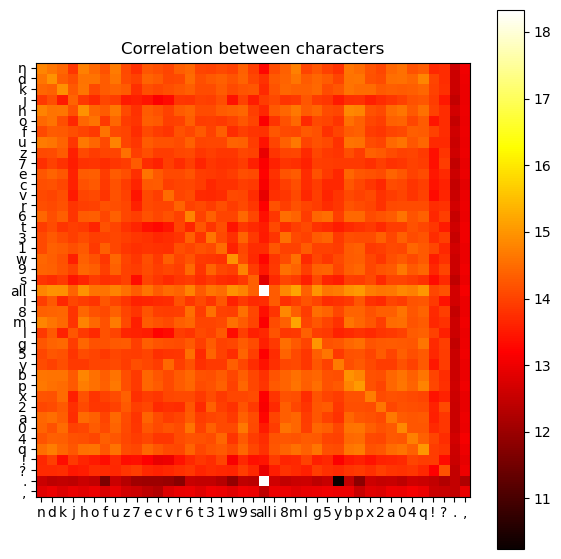

In [28]:
def correlation_heatmap(font):
    heatmap = [[np.log(correlation(font[char1], font[char2]).max()) for char2 in font] for char1 in font]
    plt.figure(figsize=(7, 7))
    plt.yticks(range(len(font)), font.keys())
    plt.xticks(range(len(font)), font.keys())
    plt.title('Correlation between characters')
    plt.colorbar(plt.imshow(heatmap, cmap='hot'))
    plt.show()

correlation_heatmap(load_fonts()['serif'])

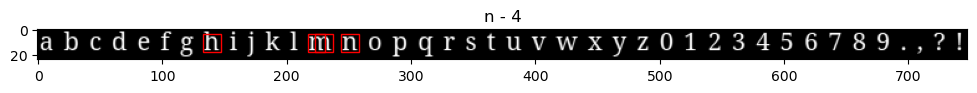

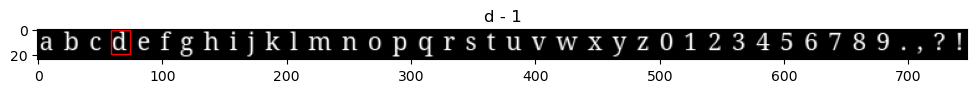

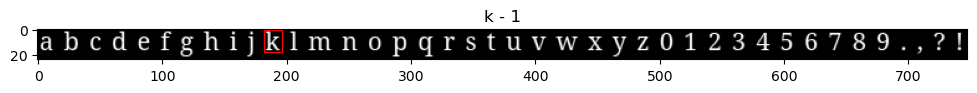

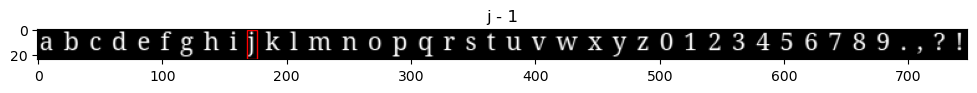

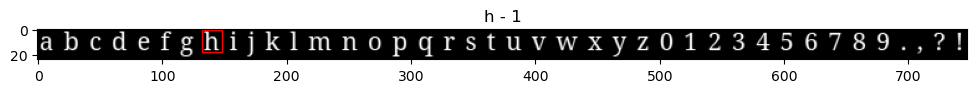

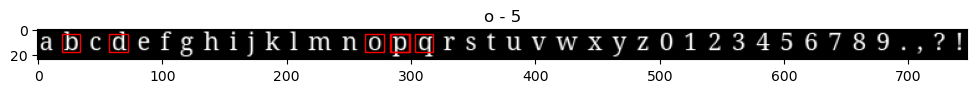

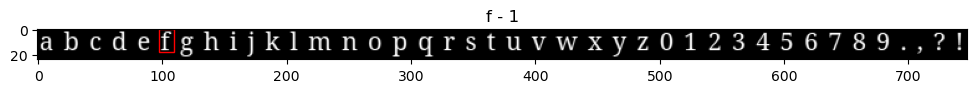

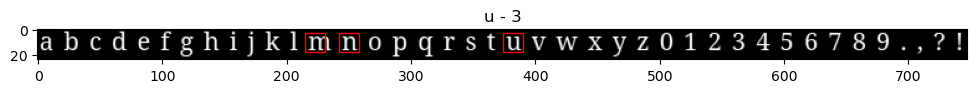

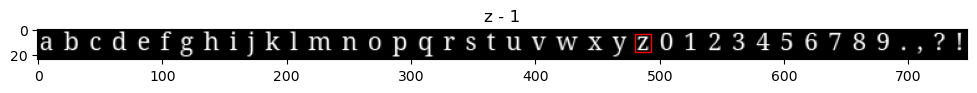

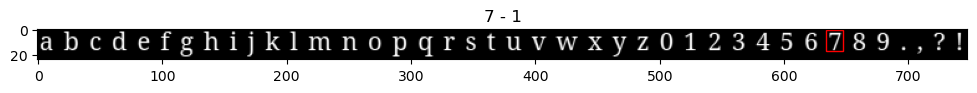

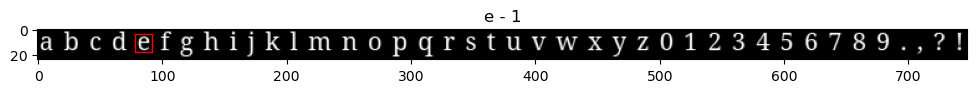

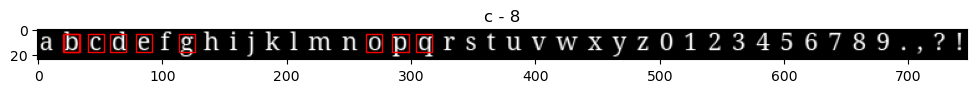

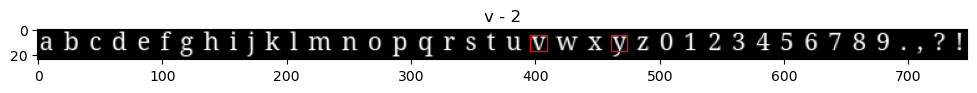

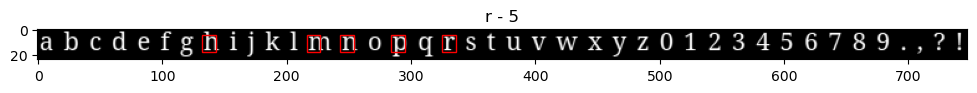

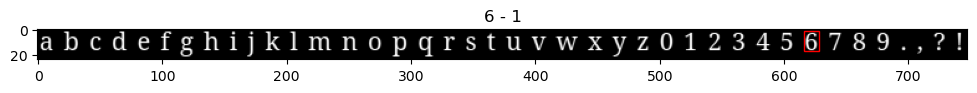

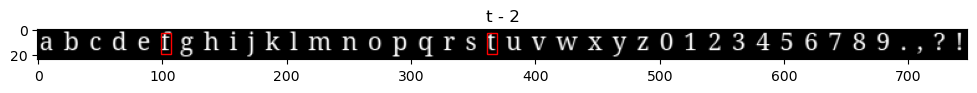

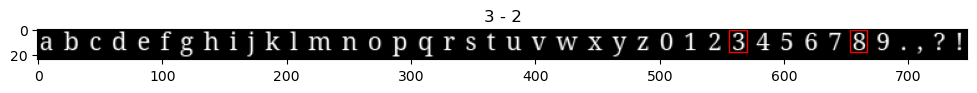

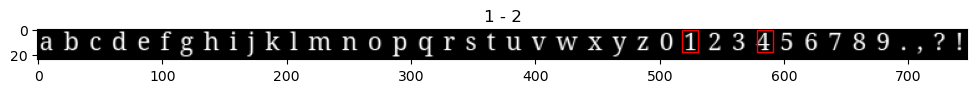

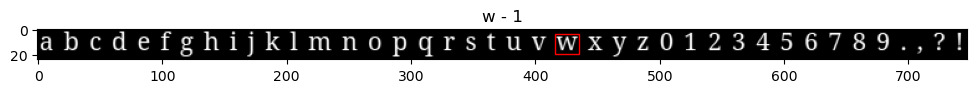

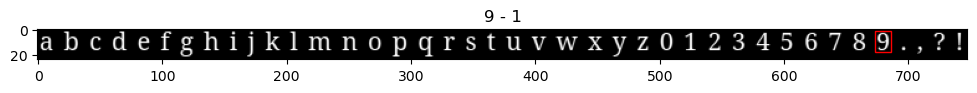

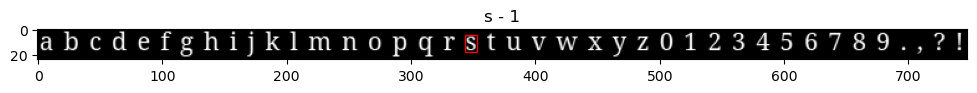

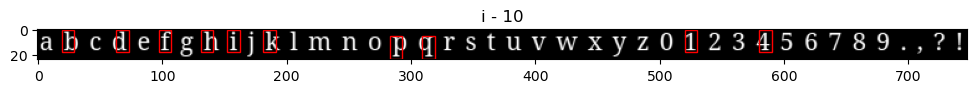

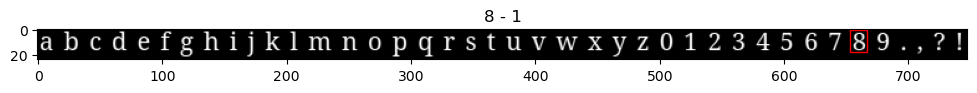

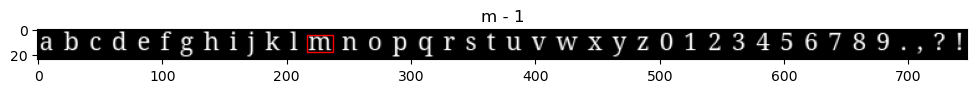

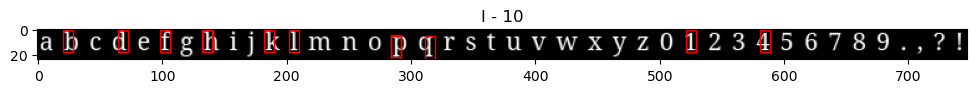

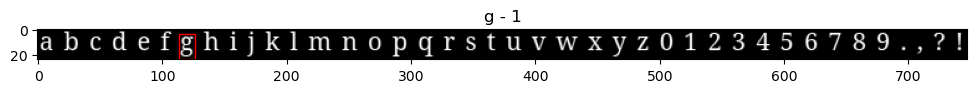

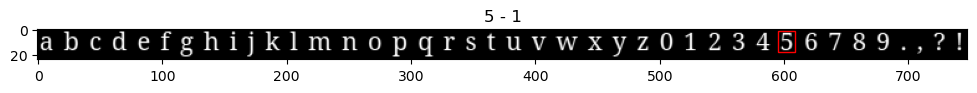

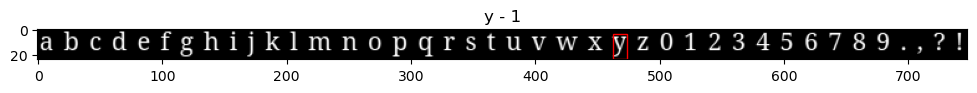

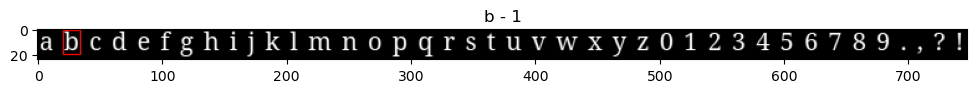

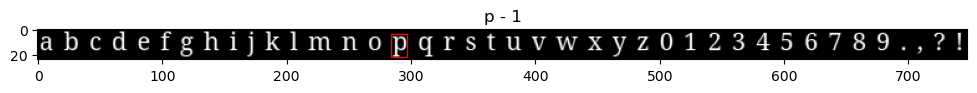

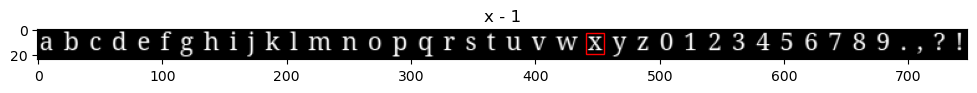

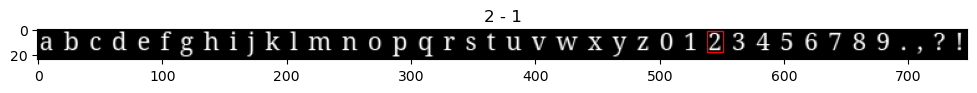

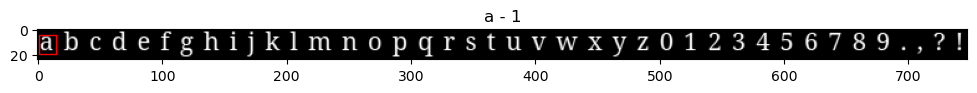

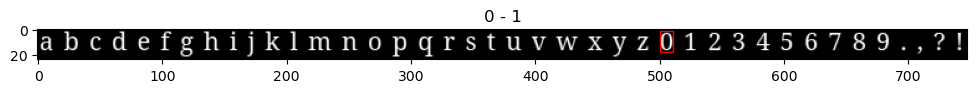

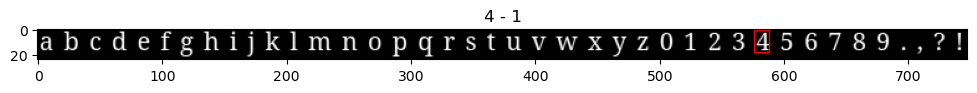

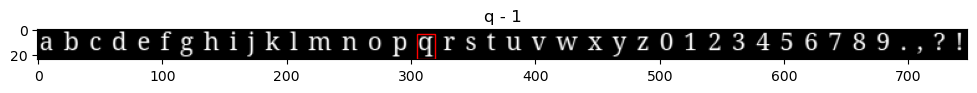

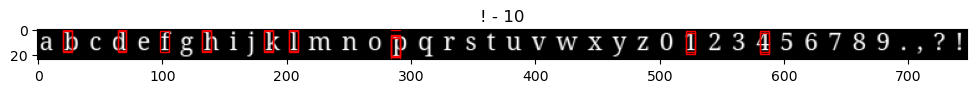

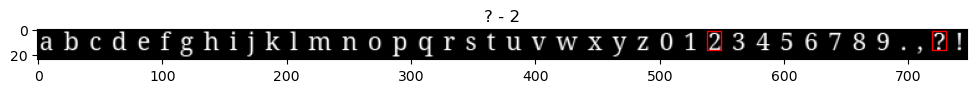

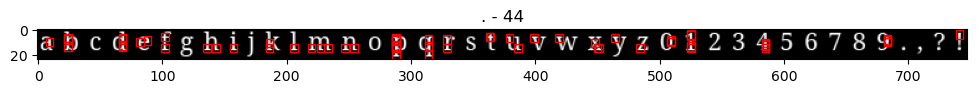

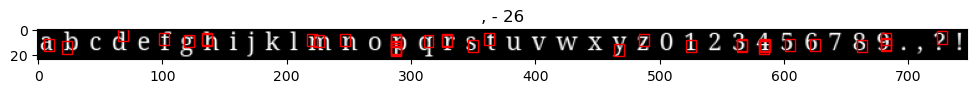

['d',
 'k',
 'j',
 'h',
 'f',
 'z',
 '7',
 'e',
 '6',
 'w',
 '9',
 's',
 '8',
 'm',
 'g',
 '5',
 'y',
 'b',
 'p',
 'x',
 '2',
 'a',
 '0',
 '4',
 'q',
 'v',
 't',
 '3',
 '1',
 '?',
 'u',
 'n',
 'o',
 'r',
 'c',
 'i',
 'l',
 '!',
 ',',
 '.']

In [34]:
def get_char_order(font, confidence=0.9, ratio=2, show=False):
    counter_dict = defaultdict(list)
    background = np.array(font['all'])

    for i, (char, img) in enumerate(font.items()):
        if char == 'all':
            continue
        sample = np.array(img)
        img_cor = correlation(background, sample)
        img_cor[img_cor<np.max(img_cor)*confidence] = 0.
        count = len(measure.find_contours(img_cor, confidence*np.max(img_cor)))
        counter_dict[count].append(char)
    
        if show:
            _, ax = plt.subplots(figsize=(background.shape[0]/ratio, background.shape[1]/ratio))
            ax.set_title(f'{char} - {count}')
            ax.imshow(background, cmap='gray')
            for i, j in np.argwhere(img_cor!=0.):
                ax.add_patch(patches.Rectangle((j,i), -sample.shape[1], -sample.shape[0], edgecolor='r', facecolor='none'))
            plt.show()
        
    result = []
    for key in sorted(counter_dict):
        result += counter_dict[key]
    return result

get_char_order(load_fonts()['serif'], show=True)

# Wykrywanie znaków

In [39]:
def read_text(image, font):
    char_order = get_char_order(font)
    enchanced = add_char_patterns(image, font)
    result = {}
    counter = {}
    for i, char in enumerate(char_order):
        sample = font[char]
        img_cor = correlation(enchanced, sample)
        img_cor[img_cor<np.max(img_cor)*0.9] = 0.
        contours = measure.find_contours(img_cor, 0.9*np.max(img_cor))
        for contour in contours:
            x, y = contour.mean(axis=0)
            result[(int(x), int(y))] = char
            counter[char] = counter.get(char, 0) + 1
    
    return counter

img = load_image('ocr/serif-image.png')
fonts = load_fonts()
test = read_text(img, fonts['serif'])
text = "1, 2, 3, 4, 5! once i caught a fish alive. 6, 7, 8, 9, 10. then i let it go again. why did you let it go? because it bit my finger so. which finger did it bite? this little finger on the right."
# count each letter in the text
ground = {char: text.count(char) for char in text}

for letter in ground.keys():
    if letter not in test.keys():
        test[letter] = 0
    
for letter in test.keys():
    if letter not in ground.keys():
        ground[letter] = 0

for letter in ground.keys():
    print(f'{letter} g-{ground[letter]} t-{test[letter]}')

1 g-2 t-4
, g-8 t-29
  g-44 t-0
2 g-1 t-2
3 g-1 t-4
4 g-1 t-2
5 g-1 t-2
! g-1 t-30
o g-6 t-18
n g-7 t-22
c g-4 t-42
e g-13 t-13
i g-20 t-52
a g-6 t-7
u g-3 t-10
g g-8 t-9
h g-9 t-9
t g-15 t-20
f g-4 t-5
s g-4 t-5
l g-5 t-31
v g-1 t-7
. g-5 t-168
6 g-1 t-2
7 g-1 t-2
8 g-1 t-2
9 g-1 t-2
0 g-1 t-2
w g-2 t-3
y g-3 t-5
d g-4 t-5
? g-2 t-5
b g-3 t-7
m g-1 t-3
r g-4 t-24
k g-0 t-1
j g-0 t-1
z g-0 t-1
p g-0 t-1
x g-0 t-1
q g-0 t-1


---